In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random


## Part 2

In [ ]:
A = np.zeros((1495, 1495),dtype=int)

file_name = 'friends.txt'
with open(file_name,'r') as file:
    for line in file:
        node1, node2 = map(int, line.strip().split(','))
        A[node1 - 1][node2 - 1] = 1

L = np.diag(np.sum(A, axis=1)) - A

eigenvalues, eigenvectors = np.linalg.eig(L)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

for i in range(20):
    print(f"Eigenvalue {i+45}: ", sorted_eigenvalues[i+45])

print(np.round(sorted_eigenvalues[:12],3))
print(sorted_eigenvectors[:,:12])

Eigenvalue 45:  0.9774050908060793
Eigenvalue 46:  0.9811690117252786
Eigenvalue 47:  0.9858013139210039
Eigenvalue 48:  0.9879890063135041
Eigenvalue 49:  0.9879961715846259
Eigenvalue 50:  0.993137411686423
Eigenvalue 51:  0.9939807127547048
Eigenvalue 52:  0.9980936596819784
Eigenvalue 53:  0.999999999999994
Eigenvalue 54:  1.000000000000015
Eigenvalue 55:  1.0000000000000304
Eigenvalue 56:  1.000000000000036
Eigenvalue 57:  1.0000000000000522
Eigenvalue 58:  1.0025213056947049
Eigenvalue 59:  1.0278409273130087
Eigenvalue 60:  1.0501106421264605
Eigenvalue 61:  1.1087148761992083
Eigenvalue 62:  1.1579292006375457
Eigenvalue 63:  1.1926265623145227
Eigenvalue 64:  1.215385158604777
[-0.    -0.    -0.     0.     0.     0.     0.014  0.054  0.074  0.081
  0.12   0.133]
[[ 0.02594874 -0.0012104  -0.00047495 ...  0.00153581  0.00044631
  -0.0025107 ]
 [ 0.02594874 -0.0012104  -0.00047495 ... -0.02638167 -0.01351995
   0.00061739]
 [ 0.02594874 -0.0012104  -0.00047495 ...  0.00153009  0

\newpage

## Part 3
There are 6 connected components in the graph as there are 6 zero eigenvalues.
To find the number of nodes in each component, we can check how many nonzero values are there in the entries of the 6 eigenvectors 

In [274]:
for i in range(6):
    v = sorted_eigenvectors[:,i]
    threshold = np.max(np.abs(v)) * 0.9 # dynamically set threshold base on the values of the eigenvector
    nodes = np.where(np.abs(v) > threshold)
    print("number of nodes in cluster", i+1, ":", len(nodes[0]))
    

number of nodes in cluster 1 : 2
number of nodes in cluster 2 : 3
number of nodes in cluster 3 : 2
number of nodes in cluster 4 : 2
number of nodes in cluster 5 : 2
number of nodes in cluster 6 : 1484



\newpage


## Part 4

In [275]:
import warnings
warnings.filterwarnings("ignore")

In [276]:
def compute_conductance(A, S):
    n = A.shape[0]
    S_complement = np.setdiff1d(np.arange(n), S) # find the complement of S
    boundary_edges = np.sum(A[np.ix_(S, S_complement)]) # find the number of boundary edges
    degree_S = np.sum(np.sum(A[S, :], axis=1)) # find the degree of S

    if degree_S == 0:
        return 1
    return boundary_edges / degree_S


def find_low_conductance_sets(A, min_size=150, max_size=750, max_conductance=0.1):
    
    selected_eigenvectors = sorted_eigenvectors[:, 6:15] 
    kmeans = KMeans(n_clusters=50, random_state=0)  
    labels = kmeans.fit_predict(selected_eigenvectors)
    

    sets = []
    for i in range(np.max(labels) + 1):
        S = np.where(labels == i)[0]
        if min_size <= len(S) <= max_size:
            conductance = compute_conductance(A, S)
            if conductance <= max_conductance:
                sets.append(S)

    return sets

sets = find_low_conductance_sets(A)

for i, S in enumerate(sets):
    print(f"S{i + 1}:")
    print(f"Size: {len(S)}")
    print(f"10 members: {S[:10]}")
    print(f"conductance: {compute_conductance(A, S)}")
    print()


S1:
Size: 198
10 members: [ 1  5  7 12 16 20 54 59 66 70]
conductance: 0.008555133079847909

S2:
Size: 550
10 members: [ 4  6 11 14 22 23 26 29 33 41]
conductance: 0.012405699916177704

S3:
Size: 506
10 members: [ 0  2  8  9 13 15 18 19 21 25]
conductance: 0.042727618220315976



## Plots of eigenvectors

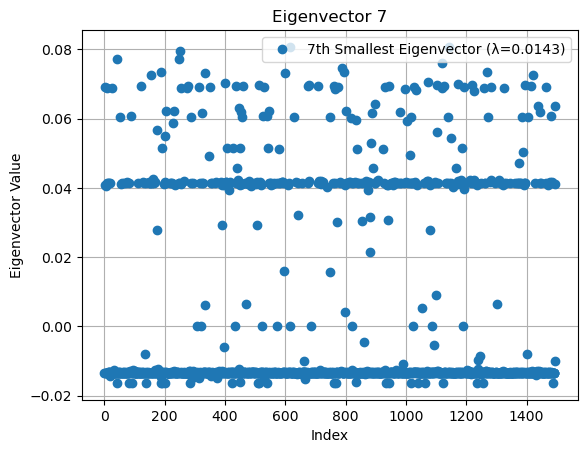

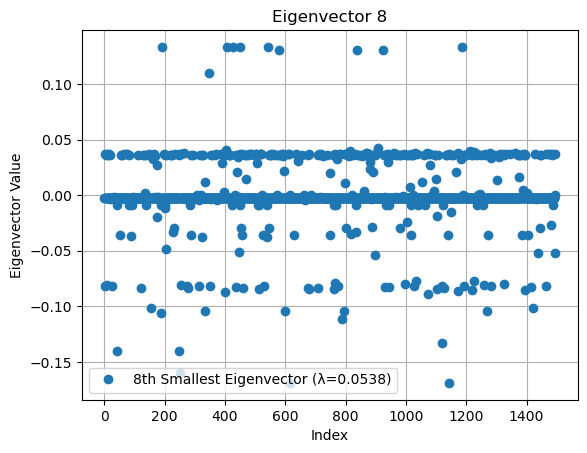

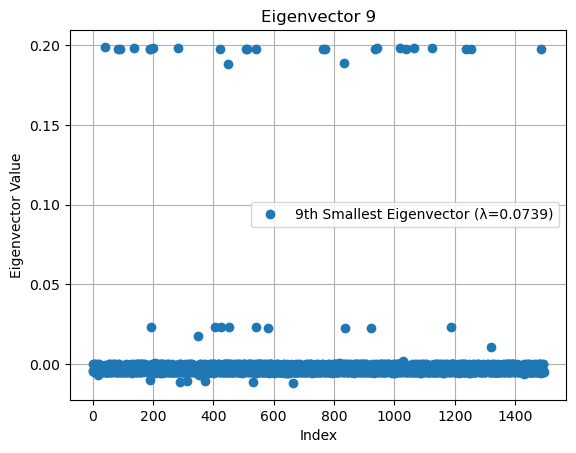

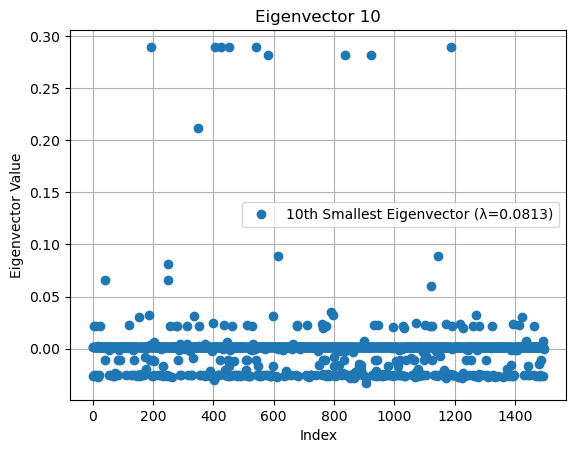

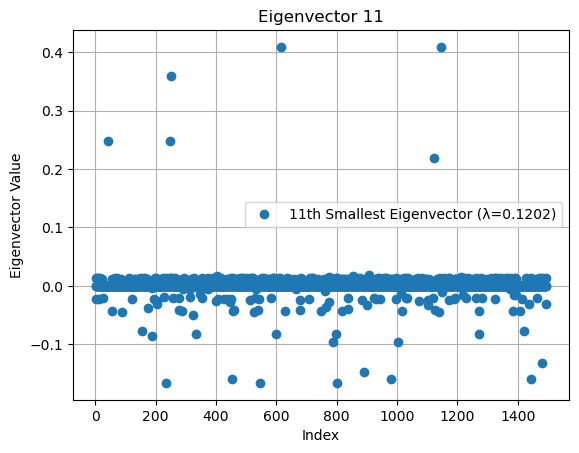

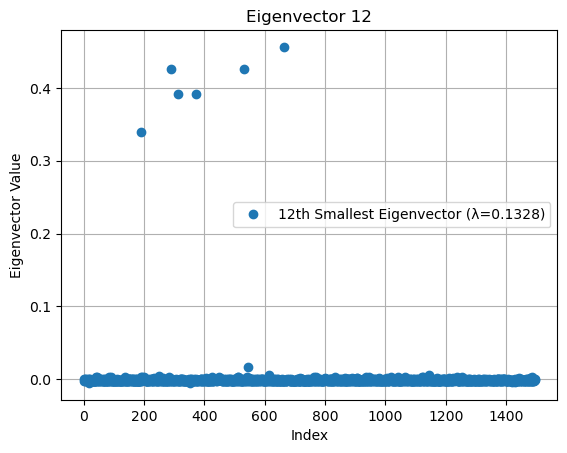

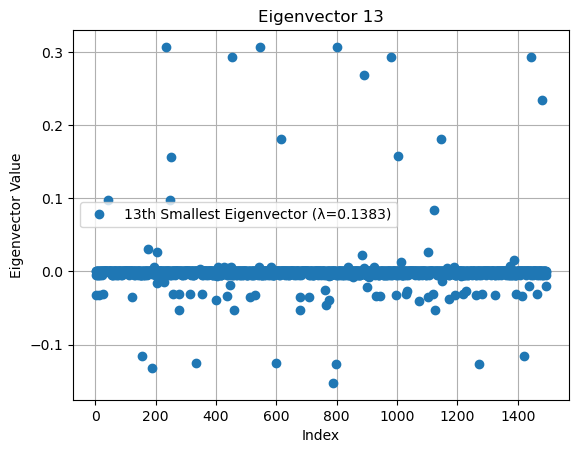

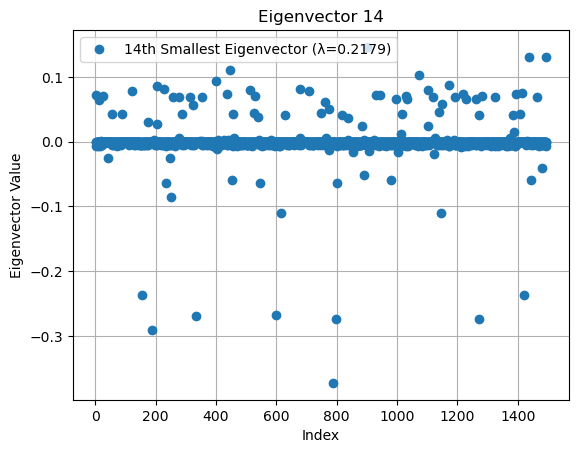

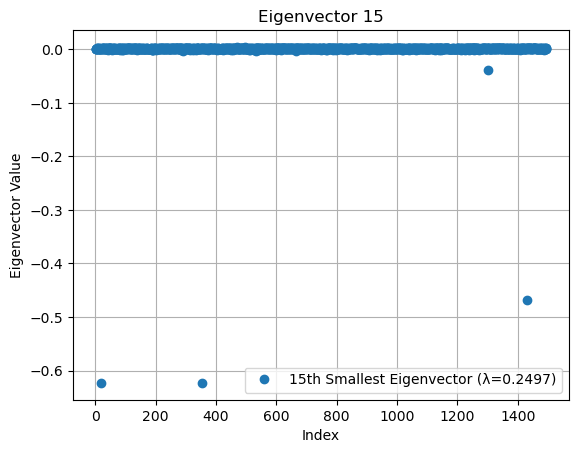

In [277]:
for i in range(6,15):
    plt.plot(range(1,1496), sorted_eigenvectors[:,i], marker='o', linestyle = 'none', label=f'{i+1}th Smallest Eigenvector (λ={sorted_eigenvalues[i]:.4f})')
    plt.xlabel('Index')
    plt.ylabel('Eigenvector Value')
    plt.title('Eigenvector ' + str(i+1))
    plt.legend()
    plt.grid(True)
    plt.show()

## The sets are distinguished by K-mean 


\newpage


## Part 5

In [278]:
added = []
while len(added) < 150:
    rand = random.randint(0, 1494)
    if rand not in added:
        added.append(rand)

print(compute_conductance(A, added))

0.9081955026946664


The conductances of sets found in part d is much smaller than the conductance obtained in this part. Meaning that the former is much tight-knit 